# 05 ERP Analysis 

## Overview

This notebook performs Event-Related Potential (ERP) analysis on the preprocessed EEG data. The workflow includes:

1. **Session Loading**: Loads session mapping and identifies available preprocessed sessions
2. **Data Synchronization**: Aligns EEG timestamps with experimental events using time offsets from filenames
3. **Event Extraction**: Reads experimental CSV to extract stimulus onset times and condition labels
4. **Epoching**: Creates time-locked segments around each stimulus event (-0.2 to 0.8 seconds)
5. **Baseline Correction**: Removes pre-stimulus baseline activity
6. **Condition Averaging**: Computes averaged ERPs for each experimental condition (AR/VR/AV × easy/difficult)
7. **Visualization**: Plots ERPs and topographic maps to examine neural responses

**Input**: 
- `session_XX-EEG-preprocessed.pkl` files (from notebook 04, after ICA artifact removal)
- Experiment CSV files (with stimulus timing and conditions)
- Session mapping CSV (to link EEG and experiment files)

**Output**: 
- `session_XX-epochs-epo.fif`: MNE epochs object containing all trials
- `session_XX-evoked-{condition}-ave.fif`: Averaged ERP waveforms per condition
- Statistical results and visualizations

## 1. Import Libaries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pickle
from pathlib import Path

# Load session mapping
df_sessions = pd.read_csv('./session_mapping.csv')
df_matched = df_sessions[df_sessions['eeg_file'] != 'NO MATCH'].copy()

# Filter for sessions with preprocessed data
available_sessions = []
for idx in df_matched.index:
    if Path(f"./preprocessed/session_{idx:02d}-EEG-preprocessed.pkl").exists():
        available_sessions.append(idx)

print(f"Available sessions: {len(available_sessions)}")
print(f"Session IDs: {available_sessions}")

Available sessions: 2
Session IDs: [0, 1]


## 1a. Calculate Average Time Offset Across All Sessions

In [2]:
# Calculate average time offset across all available sessions
print("="*70)
print("TIME OFFSET ANALYSIS - ALL SESSIONS")
print("="*70)

offsets = []

for sess_id in available_sessions:
    # Get session info
    sess_info = df_matched.loc[sess_id]
    exp_file_temp = sess_info['experiment_file']
    eeg_file_temp = sess_info['eeg_file']
    
    # Load experiment data
    df_exp_temp = pd.read_csv(f'./Data/{exp_file_temp}', engine='python', on_bad_lines='skip')
    
    # Get timestamps
    exp_start = df_exp_temp['el_recording.started_Unix'].dropna().iloc[0]
    eeg_start = int(eeg_file_temp.split('_')[-1].replace('.csv', ''))
    
    # Calculate offset
    offset_sec = exp_start - eeg_start
    offset_min = offset_sec / 60
    
    offsets.append({
        'session_id': sess_id,
        'offset_seconds': offset_sec,
        'offset_minutes': offset_min
    })
    
    print(f"Session {sess_id:2d}: {offset_min:6.2f} minutes ({offset_sec:7.1f} seconds)")

# Calculate statistics
df_offsets = pd.DataFrame(offsets)
avg_offset_min = df_offsets['offset_minutes'].mean()
std_offset_min = df_offsets['offset_minutes'].std()
min_offset_min = df_offsets['offset_minutes'].min()
max_offset_min = df_offsets['offset_minutes'].max()

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Average offset: {avg_offset_min:.2f} ± {std_offset_min:.2f} minutes")
print(f"Range: {min_offset_min:.2f} to {max_offset_min:.2f} minutes")
print(f"Total sessions: {len(offsets)}")

# Check if offsets are consistent
if std_offset_min > 1.0:
    print(f"\n⚠️ WARNING: High variability in time offsets (SD={std_offset_min:.2f} min)")
    print(f"   This suggests inconsistent timing between EEG and experiment recordings")
else:
    print(f"\n✓ Time offsets are relatively consistent across sessions")

TIME OFFSET ANALYSIS - ALL SESSIONS
Session  0:  38.80 minutes ( 2328.0 seconds)
Session  1:   1.48 minutes (   88.8 seconds)

SUMMARY STATISTICS
Average offset: 20.14 ± 26.39 minutes
Range: 1.48 to 38.80 minutes
Total sessions: 2

⚠️ WARNING: High variability in time offsets (SD=26.39 min)
   This suggests inconsistent timing between EEG and experiment recordings


## 2. Load Preprocessed EEG Data

In [5]:
# Select session to analyze (change this to analyze different sessions)
session_id = available_sessions[1]  # Start with first available session - change number as needed!!

# Get session info
session_info = df_matched.loc[session_id]
exp_file = session_info['experiment_file']
eeg_file = session_info['eeg_file']
time_offset_min = session_info['time_offset_min']

# Load preprocessed EEG
with open(f'./preprocessed/session_{session_id:02d}-EEG-preprocessed.pkl', 'rb') as f:    
    raw = pickle.load(f)

print(f"Analyzing Session {session_id}:")
print(f"  Experiment: {exp_file}")
print(f"  EEG: {eeg_file}")
print(f"  Time offset: {time_offset_min:.1f} minutes")

print(f"\nEEG Info:")
print(f"  Sampling rate: {raw.info['sfreq']} Hz")
print(f"  Channels: {len(raw.ch_names)}")
print(f"  Total samples: {len(raw.times)}")
print(f"  Duration: {raw.times[-1]:.1f} seconds")

Analyzing Session 1:
  Experiment: 01_human-llm-alignment_2025-11-20_13h16.37.791.csv
  EEG: EEG_data_1763640940.csv
  Time offset: 1.5 minutes

EEG Info:
  Sampling rate: 500.0 Hz
  Channels: 64
  Total samples: 1053511
  Duration: 2107.0 seconds


## 3. Load Experiment Events from CSV

In [6]:
# Load experiment data for this session
df_exp = pd.read_csv(f'./Data/{exp_file}', engine='python', on_bad_lines='skip')

# Filter rows with valid AI_Response.started times (this is when AI alignment stimuli are shown)
df_events = df_exp[df_exp['AI_Response.started'].notna()].copy()

print(f"Found {len(df_events)} AI stimulus events")
print(f"\nEvent timing:")
print(f"  First event: {df_events['AI_Response.started'].min():.2f}s")
print(f"  Last event: {df_events['AI_Response.started'].max():.2f}s")
print(f"\nConditions:")
print(df_events['Alignment'].value_counts())

Found 18 AI stimulus events

Event timing:
  First event: 126.89s
  Last event: 2247.67s

Conditions:
Alignment
medium    8
low       5
high      5
Name: count, dtype: int64


## 4. Calculate EEG Recording Start Time

In [7]:
# Get experiment start time from el_recording.started_Unix
exp_start_unix = df_exp['el_recording.started_Unix'].dropna().iloc[0]
print(f"Experiment recording start: {exp_start_unix}")

# Extract EEG start time from EEG filename (e.g., EEG_data_1763373596.csv)
eeg_start_unix = int(eeg_file.split('_')[-1].replace('.csv', ''))
print(f"EEG recording start: {eeg_start_unix}")

# Time offset between EEG start and experiment start (in seconds)
time_offset = exp_start_unix - eeg_start_unix
print(f"\nTime offset: {time_offset:.2f} seconds ({time_offset/60:.2f} minutes)")
print(f"EEG started {time_offset:.0f}s BEFORE experiment")

Experiment recording start: 1763641028.8121908
EEG recording start: 1763640940

Time offset: 88.81 seconds (1.48 minutes)
EEG started 89s BEFORE experiment


## 5. Create MNE Events Array

In [8]:
# Convert AI_Response.started times to EEG sample indices
sfreq = raw.info['sfreq']  # 500 Hz

# Calculate absolute event times in EEG recording
# AI_Response.started is relative to experiment start, add offset to get EEG time
event_times_eeg = df_events['AI_Response.started'].values + time_offset

# Convert to sample indices
event_samples = (event_times_eeg * sfreq).astype(int)

# Create event IDs for conditions
event_id = {'high': 1, 'medium': 2, 'low': 3}
event_codes = df_events['Alignment'].map(event_id).values

# Create MNE events array: [sample, 0, event_id]
events = np.column_stack([event_samples, np.zeros(len(event_samples), dtype=int), event_codes])

print(f"Created {len(events)} events")
print(f"Event samples range: {event_samples.min()} to {event_samples.max()}")
print(f"EEG total samples: {len(raw.times)}")
print(f"\nEvent distribution:")
for condition, code in event_id.items():
    count = np.sum(events[:, 2] == code)
    print(f"  {condition}: {count} events")

Created 18 events
Event samples range: 107850 to 1168239
EEG total samples: 1053511

Event distribution:
  high: 5 events
  medium: 8 events
  low: 5 events


## 6. Verify Event Timing

In [9]:
# Check if events fall within EEG recording
valid_events = (events[:, 0] >= 0) & (events[:, 0] < len(raw.times))
print(f"Valid events (within EEG recording): {valid_events.sum()} / {len(events)}")

if not valid_events.all():
    print("\nWARNING: Some events are outside EEG recording!")
    print(f"First event sample: {events[0, 0]}")
    print(f"Last event sample: {events[-1, 0]}")
    print(f"EEG samples: 0 to {len(raw.times)}")
else:
    print("✓ All events are within EEG recording bounds")

Valid events (within EEG recording): 16 / 18

First event sample: 107850
Last event sample: 1168239
EEG samples: 0 to 1053511


## 7. Create Epochs with Autoreject

**Autoreject** automatically identifies and removes bad epochs based on local amplitude thresholds for each channel. This helps eliminate trials with extreme artifacts (eye movements, muscle tension, etc.) that would distort the ERP.


In [10]:
from autoreject import AutoReject

# Epoch parameters
tmin = -0.5  # Extended baseline: 500ms before stimulus (better baseline estimate)
tmax = 0.8   # 800ms after stimulus
baseline = (-0.5, -0.1)  # Use -500 to -100ms for baseline (avoids stimulus onset effects)

# Filter event_id to only include conditions present in the data
available_event_id = {}
for condition, code in event_id.items():
    if np.any(events[:, 2] == code):
        available_event_id[condition] = code
        
print(f"Available conditions in data: {list(available_event_id.keys())}")

# Create epochs WITHOUT baseline correction first (AutoReject works better on raw data)
epochs = mne.Epochs(
    raw, 
    events, 
    event_id=available_event_id,
    tmin=tmin, 
    tmax=tmax,
    baseline=None,  # Apply baseline AFTER artifact rejection
    preload=True,
    reject=None,  # Don't use automatic rejection yet
    verbose=True
)

print(f"\nEpochs created (before artifact rejection):")
print(f"  Total: {len(epochs)}")
for condition in available_event_id.keys():
    print(f"  {condition}: {len(epochs[condition])}")
print(f"  Time window: {tmin} to {tmax} seconds")

# Apply AutoReject to remove bad epochs
print("\n" + "="*60)
print("Applying AutoReject artifact detection...")
print("="*60)

# Adapt cross-validation folds to number of epochs
n_epochs = len(epochs)

if n_epochs < 5:
    print(f"⚠️ CRITICAL: Only {n_epochs} epochs - AutoReject requires minimum 5 epochs")
    print(f"   Falling back to simple peak-to-peak amplitude rejection...")
    
    # Simple rejection based on peak-to-peak amplitude
    reject_threshold = dict(eeg=100e-6)  # 100 µV threshold
    epochs_clean = epochs.copy().drop_bad(reject=reject_threshold)
    
    print(f"   Rejected {len(epochs) - len(epochs_clean)} epochs with amplitude >100 µV")
    
else:
    cv_folds = min(5, n_epochs)  # Use max 5 folds, or fewer if not enough epochs
    
    if n_epochs < 10:
        print(f"⚠️ Warning: Only {n_epochs} epochs available")
        print(f"   Using {cv_folds}-fold cross-validation (adapted from default 10-fold)")
    
    try:
        ar = AutoReject(n_interpolate=[1, 2, 4], cv=cv_folds, random_state=42, n_jobs=1, verbose=True)
        epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True)
    except ValueError as e:
        print(f"\n⚠️ AutoReject failed: {e}")
        print(f"   Falling back to simple amplitude rejection...")
        
        reject_threshold = dict(eeg=100e-6)
        epochs_clean = epochs.copy().drop_bad(reject=reject_threshold)
        print(f"   Rejected {len(epochs) - len(epochs_clean)} epochs with amplitude >100 µV")

# Apply baseline correction AFTER artifact rejection
epochs_clean.apply_baseline(baseline)

print(f"\n" + "="*60)
print("Artifact Rejection Summary:")
print("="*60)
print(f"Original epochs: {len(epochs)}")
print(f"Clean epochs: {len(epochs_clean)}")
print(f"Rejected: {len(epochs) - len(epochs_clean)} ({100*(len(epochs)-len(epochs_clean))/len(epochs):.1f}%)")
print(f"\nPer condition (after rejection):")
for condition in available_event_id.keys():
    n_clean = len(epochs_clean[condition])
    n_original = len(epochs[condition])
    if n_original > 0:
        print(f"  {condition}: {n_clean}/{n_original} ({100*n_clean/n_original:.1f}% retained)")
    else:
        print(f"  {condition}: {n_clean}/0 (condition had no epochs)")

# Replace epochs with cleaned version
epochs = epochs_clean

Available conditions in data: ['high', 'medium', 'low']
Not setting metadata
18 matching events found
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 651 original time points ...
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 651 original time points ...
2 bad epochs dropped
2 bad epochs dropped


c:\Users\kimbe\iCloudDrive\Master\Masterarbeit\Analyse\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epochs created (before artifact rejection):
  Total: 16
  high: 4
  medium: 7
  low: 5
  Time window: -0.5 to 0.8 seconds

Applying AutoReject artifact detection...
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 64/64 [00:01<00:00,   59.25it/s]
  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]
100%|██████████| Computing thresholds ... : 64/64 [00:30<00:00,    2.08it/s]


























100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   56.42it/s]
100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   56.42it/s]


































100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   42.33it/s]

100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   42.33it/s]






















100%|██████████| Fold : 5/5 [00:00<00:00,    6.15it/s]


100%|██████████| Fold : 5/5 [00:00<00:00,    6.15it/s]

































100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   46.39it/s]




100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   46.39it/s]



















100%|██████████| Fold : 5/5 [00:00<00:00,    5.57it/s]


100%|██████████| Fold : 5/5 [00:00<00:00,    5.57it





Estimated consensus=0.40 and n_interpolate=4


































100%|██████████| Repairing epochs : 16/16 [00:00<00:00,   41.51it/s]

Dropped 10 epochs: 0, 2, 5, 7, 8, 9, 10, 11, 12, 13


Applying baseline correction (mode: mean)

Artifact Rejection Summary:
Original epochs: 16
Clean epochs: 6
Rejected: 10 (62.5%)

Per condition (after rejection):
  high: 0/4 (0.0% retained)
  medium: 3/7 (42.9% retained)
  low: 3/5 (60.0% retained)

Artifact Rejection Summary:
Original epochs: 16
Clean epochs: 6
Rejected: 10 (62.5%)

Per condition (after rejection):
  high: 0/4 (0.0% retained)
  medium: 3/7 (42.9% retained)
  low: 3/5 (60.0% retained)


In [11]:
# DIAGNOSTIC: Why so few epochs?
print("\n" + "="*70)
print("DIAGNOSTIC - Why does this session have so few epochs?")
print("="*70)

print(f"\nOriginal events from experiment CSV: {len(df_events)}")
print(f"  Condition breakdown: {df_events['Alignment'].value_counts().to_dict()}")

print(f"\nEpochs created by MNE: {len(epochs)}")
print(f"  Events dropped during epoching: {len(df_events) - len(epochs)}")

# Check drop log
if hasattr(epochs, 'drop_log'):
    n_dropped = sum([1 for log in epochs.drop_log if len(log) > 0])
    print(f"  Epochs dropped due to issues: {n_dropped}")
    
    if n_dropped > 0:
        from collections import Counter
        reasons = []
        for log in epochs.drop_log:
            if len(log) > 0:
                reasons.extend(log)
        print(f"\n  Drop reasons: {Counter(reasons)}")
        
        # Most common reason
        if reasons:
            most_common = Counter(reasons).most_common(1)[0]
            print(f"\n  Most common issue: '{most_common[0]}' ({most_common[1]} epochs)")
            
            if 'BAD' in most_common[0] or 'IGNORED' in most_common[0]:
                print(f"\n  💡 This means events fell outside the valid EEG recording time.")
                print(f"     Likely causes:")
                print(f"     - EEG recording stopped before experiment ended")
                print(f"     - Wrong time offset calculated")
                print(f"     - Epoch window (-0.5 to 0.8s) extends beyond recording bounds")

print(f"\nPer condition (before AutoReject):")
for condition in available_event_id.keys():
    print(f"  {condition}: {len(epochs[condition])} epochs")
    
print(f"\n⚠️ Note: With only {len(epochs)} epochs, AutoReject may struggle.")
print(f"   Minimum recommended: 15-20 epochs per condition")


DIAGNOSTIC - Why does this session have so few epochs?

Original events from experiment CSV: 18
  Condition breakdown: {'medium': 8, 'low': 5, 'high': 5}

Epochs created by MNE: 6
  Events dropped during epoching: 12
  Epochs dropped due to issues: 12

  Drop reasons: Counter({'AUTOREJECT': 10, 'TOO_SHORT': 2})

  Most common issue: 'AUTOREJECT' (10 epochs)

Per condition (before AutoReject):
  high: 0 epochs
  medium: 3 epochs
  low: 3 epochs

⚠️ Note: With only 6 epochs, AutoReject may struggle.
   Minimum recommended: 15-20 epochs per condition


In [12]:
# Additional manual peak-to-peak amplitude check (backup safety)
print("\n" + "="*60)
print("Additional Amplitude Check (Peak-to-Peak Threshold)")
print("="*60)

# Calculate peak-to-peak amplitude for each epoch
ptp_threshold = 150e-6  # 150 µV in volts
ptp_amplitudes = np.ptp(epochs.get_data(), axis=2).max(axis=1)

# Find epochs exceeding threshold
bad_ptp_epochs = ptp_amplitudes > ptp_threshold

if bad_ptp_epochs.any():
    print(f"Found {bad_ptp_epochs.sum()} epochs with amplitude >{ptp_threshold*1e6:.0f} µV")
    print(f"Removing these extreme outliers...")
    epochs.drop(np.where(bad_ptp_epochs)[0])
    print(f"Remaining epochs: {len(epochs)}")
else:
    print(f"✓ All epochs within {ptp_threshold*1e6:.0f} µV threshold")

print(f"\nFinal epoch counts:")
for condition in available_event_id.keys():
    print(f"  {condition}: {len(epochs[condition])}")


Additional Amplitude Check (Peak-to-Peak Threshold)
Found 1 epochs with amplitude >150 µV
Removing these extreme outliers...
Dropped 1 epoch: 4
Remaining epochs: 5

Final epoch counts:
  high: 0
  medium: 3
  low: 2
Remaining epochs: 5

Final epoch counts:
  high: 0
  medium: 3
  low: 2


## 8. Compute ERPs (Average Epochs)

In [13]:
# Check epoch counts per condition
print("Epoch counts per condition:")
for condition in available_event_id.keys():
    print(f"  {condition}: {len(epochs[condition])} epochs")

# Check if any expected conditions are missing
missing_conditions = [cond for cond in ['high', 'medium', 'low'] if cond not in available_event_id]
if missing_conditions:
    print(f"\nNote: The following conditions were not present in the data: {missing_conditions}")

Epoch counts per condition:
  high: 0 epochs
  medium: 3 epochs
  low: 2 epochs


In [14]:
# Compute ERPs for each condition (only if epochs exist)
evokeds = {}

# Check each possible condition
if 'high' in available_event_id and len(epochs['high']) > 0:
    evokeds['high'] = epochs['high'].average()
    print(f"✓ High alignment ERP: {len(epochs['high'])} epochs averaged")
elif 'high' in available_event_id:
    print("✗ High alignment: No epochs available (all dropped)")
else:
    print("✗ High alignment: Not present in data")

if 'medium' in available_event_id and len(epochs['medium']) > 0:
    evokeds['medium'] = epochs['medium'].average()
    print(f"✓ Medium alignment ERP: {len(epochs['medium'])} epochs averaged")
elif 'medium' in available_event_id:
    print("✗ Medium alignment: No epochs available (all dropped)")
else:
    print("✗ Medium alignment: Not present in data")

if 'low' in available_event_id and len(epochs['low']) > 0:
    evokeds['low'] = epochs['low'].average()
    print(f"✓ Low alignment ERP: {len(epochs['low'])} epochs averaged")
elif 'low' in available_event_id:
    print("✗ Low alignment: No epochs available (all dropped)")
else:
    print("✗ Low alignment: Not present in data")

# For convenience, also create individual variables
evoked_high = evokeds.get('high')
evoked_medium = evokeds.get('medium')
evoked_low = evokeds.get('low')

print(f"\nTotal ERPs computed: {len(evokeds)}")

✗ High alignment: No epochs available (all dropped)
✓ Medium alignment ERP: 3 epochs averaged
✓ Low alignment ERP: 2 epochs averaged

Total ERPs computed: 2


## 9. Visualize ERPs

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


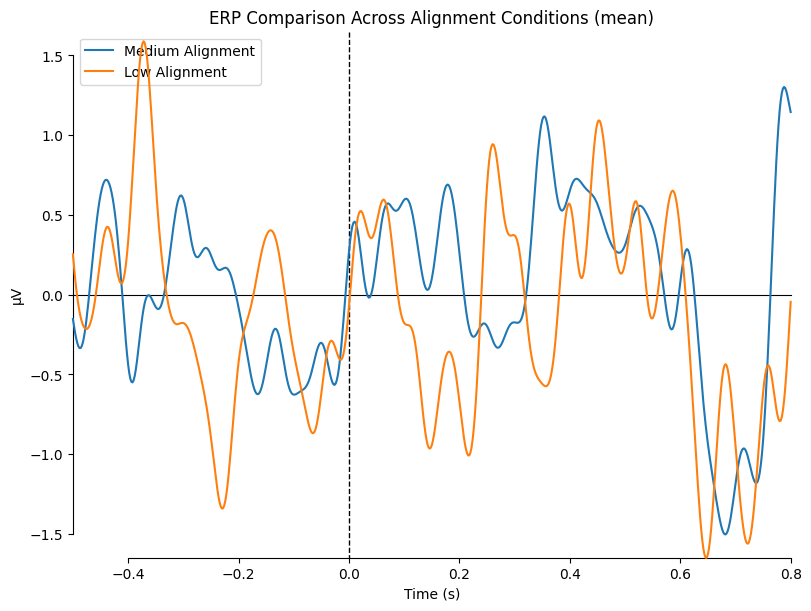

In [15]:
# Plot ERPs for all conditions together
# Build dictionary with only available evoked data
evokeds_to_plot = {}
if evoked_high is not None:
    evokeds_to_plot['High Alignment'] = evoked_high
if evoked_medium is not None:
    evokeds_to_plot['Medium Alignment'] = evoked_medium
if evoked_low is not None:
    evokeds_to_plot['Low Alignment'] = evoked_low

if len(evokeds_to_plot) > 0:
    fig = mne.viz.plot_compare_evokeds(
        evokeds_to_plot,
        picks='eeg',
        combine='mean',
        title='ERP Comparison Across Alignment Conditions'
    )
    plt.show()
else:
    print("No ERPs available to plot")

Medium Alignment:


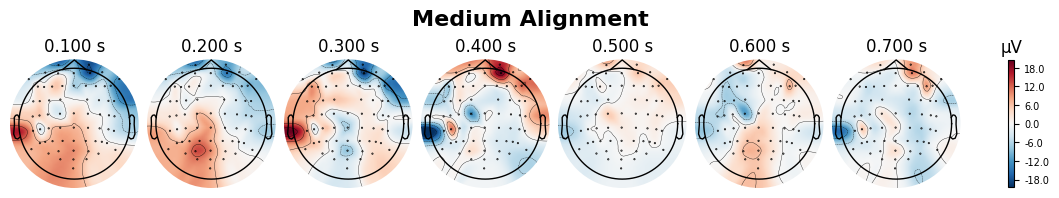

Low Alignment:


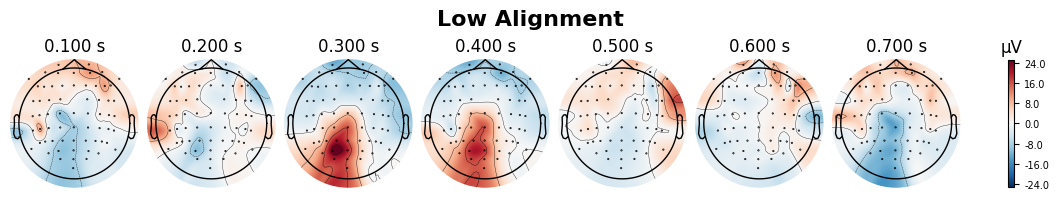

In [16]:
# Plot topographic maps at different time points (only for available conditions)
times = np.arange(0.1, 0.8, 0.1)  # Every 100ms from 100-800ms

# Plot each condition separately
if evoked_high is not None:
    print("High Alignment:")
    fig = evoked_high.plot_topomap(times=times, ch_type='eeg', show=False)
    plt.suptitle('High Alignment', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

if evoked_medium is not None:
    print("Medium Alignment:")
    fig = evoked_medium.plot_topomap(times=times, ch_type='eeg', show=False)
    plt.suptitle('Medium Alignment', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

if evoked_low is not None:
    print("Low Alignment:")
    fig = evoked_low.plot_topomap(times=times, ch_type='eeg', show=False)
    plt.suptitle('Low Alignment', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

if evoked_high is None and evoked_medium is None and evoked_low is None:
    print("No conditions available to plot")

## 10. Plot Individual Condition ERPs

In [17]:
# High alignment
if evoked_high is not None:
    evoked_high.plot(spatial_colors=True, gfp=True, 
                     window_title='High Alignment ERP')
    plt.show()
else:
    print("No high alignment ERP available")

No high alignment ERP available


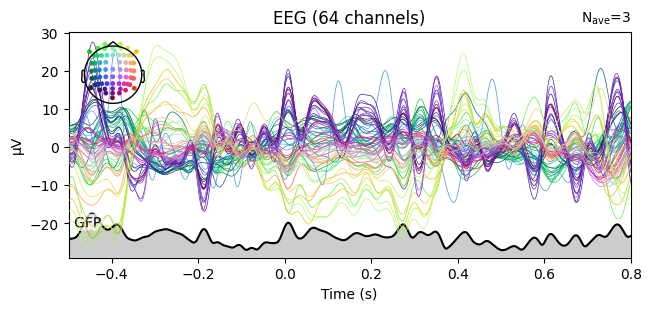

In [18]:
# Medium alignment
if evoked_medium is not None:
    evoked_medium.plot(spatial_colors=True, gfp=True, 
                       window_title='Medium Alignment ERP')
    plt.show()
else:
    print("No medium alignment ERP available")

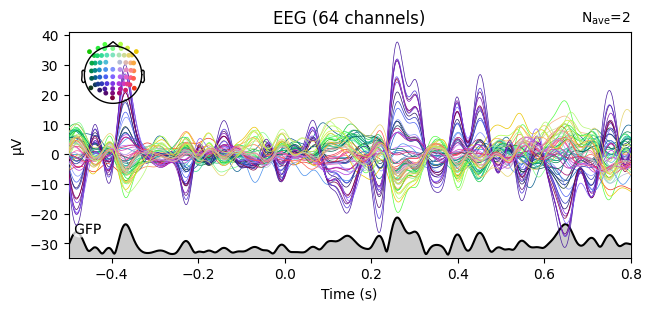

In [19]:
# Low alignment
if evoked_low is not None:
    evoked_low.plot(spatial_colors=True, gfp=True, 
                    window_title='Low Alignment ERP')
    plt.show()
else:
    print("No low alignment ERP available (all epochs were dropped)")

## 11. Save Results

In [20]:
# Save epochs
epochs.save(f'./preprocessed/session_{session_id:02d}-epochs-epo.fif', overwrite=True)
print(f"Epochs saved to: ./preprocessed/session_{session_id:02d}-epochs-epo.fif")

# Save ERPs (only those that exist)
if evoked_high is not None:
    evoked_high.save(f'./preprocessed/session_{session_id:02d}-evoked-high-ave.fif', overwrite=True)
    print("High alignment ERP saved")
    
if evoked_medium is not None:
    evoked_medium.save(f'./preprocessed/session_{session_id:02d}-evoked-medium-ave.fif', overwrite=True)
    print("Medium alignment ERP saved")
    
if evoked_low is not None:
    evoked_low.save(f'./preprocessed/session_{session_id:02d}-evoked-low-ave.fif', overwrite=True)
    print("Low alignment ERP saved")
    
print(f"\nAll available ERPs saved to: ./preprocessed/session_{session_id:02d}-evoked-*.fif")

Epochs saved to: ./preprocessed/session_01-epochs-epo.fif
Medium alignment ERP saved
Low alignment ERP saved

All available ERPs saved to: ./preprocessed/session_01-evoked-*.fif


## 12. Export Data for Analysis

In [22]:
# Export ERPs as CSV for further analysis
import os
os.makedirs('./results', exist_ok=True)

# Build dataframe with available conditions
if evoked_high is not None:
    # Use the first available condition to get time points
    ch_idx = evoked_high.ch_names.index('Cz')
    
    df_erp = pd.DataFrame({
        'time': evoked_high.times * 1000,  # Convert to ms
        'session_id': session_id,
    })
    
    if evoked_high is not None:
        df_erp['high'] = evoked_high.data[ch_idx, :] * 1e6  # Convert to µV
    
    if evoked_medium is not None:
        df_erp['medium'] = evoked_medium.data[ch_idx, :] * 1e6
    
    if evoked_low is not None:
        df_erp['low'] = evoked_low.data[ch_idx, :] * 1e6
    
    df_erp.to_csv(f'./results/erp_session_{session_id:02d}_Cz.csv', index=False)
    print(f"ERP data (Cz electrode) saved to: ./results/erp_session_{session_id:02d}_Cz.csv")
    print(f"Exported conditions: {[col for col in df_erp.columns if col not in ['time', 'session_id']]}")
else:
    print("No ERPs available to export")

No ERPs available to export


## 13. ERP Peak Detection and Analysis

Automatic detection of peaks and troughs in the ERP waveforms to identify potential ERP components.

In [23]:
from scipy.signal import find_peaks

def find_erp_peaks_auto(evoked, channel='Pz', tmin=0.0, tmax=0.8, height_threshold=None):
    """
    Automatically detects positive and negative peaks in ERP data.
    
    Parameters:
    -----------
    evoked : mne.Evoked
        Evoked object containing ERP data
    channel : str
        Channel name to analyze
    tmin, tmax : float
        Time window in seconds
    height_threshold : float or None
        Minimum absolute amplitude in µV (if None, uses data-driven threshold)
    
    Returns:
    --------
    dict with 'positive' and 'negative' peaks, each containing times and amplitudes
    """
    if evoked is None or channel not in evoked.ch_names:
        return None
    
    # Extract data
    evoked_crop = evoked.copy().crop(tmin=tmin, tmax=tmax)
    ch_idx = evoked_crop.ch_names.index(channel)
    data = evoked_crop.data[ch_idx, :] * 1e6  # Convert to µV
    times = evoked_crop.times
    
    # Set adaptive threshold if not provided
    if height_threshold is None:
        height_threshold = np.std(data) * 0.5  # Use 0.5 * standard deviation
    
    # Find positive peaks
    pos_peaks, pos_properties = find_peaks(data, height=height_threshold, distance=50)
    
    # Find negative peaks (invert signal)
    neg_peaks, neg_properties = find_peaks(-data, height=height_threshold, distance=50)
    
    results = {
        'positive': {
            'times': times[pos_peaks] * 1000,  # Convert to ms
            'amplitudes': data[pos_peaks],
            'indices': pos_peaks
        },
        'negative': {
            'times': times[neg_peaks] * 1000,
            'amplitudes': data[neg_peaks],
            'indices': neg_peaks
        },
        'channel': channel,
        'time_window': (tmin, tmax)
    }
    
    return results

# Analyze all available conditions
print("=== AUTOMATIC PEAK DETECTION ===\n")

channels_to_analyze = ['Pz', 'Cz', 'Fz']
peak_results = {}

for condition_name, evoked in [('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]:
    if evoked is not None:
        print(f"\n{condition_name} Alignment:")
        print("-" * 50)
        
        peak_results[condition_name] = {}
        
        for ch in channels_to_analyze:
            if ch in evoked.ch_names:
                peaks = find_erp_peaks_auto(evoked, channel=ch, tmin=0.0, tmax=0.8)
                peak_results[condition_name][ch] = peaks
                
                print(f"\n  {ch}:")
                print(f"    Positive peaks: {len(peaks['positive']['times'])}")
                if len(peaks['positive']['times']) > 0:
                    for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
                        print(f"      Peak {i+1}: {amp:6.2f} µV at {t:6.1f} ms")
                
                print(f"    Negative peaks: {len(peaks['negative']['times'])}")
                if len(peaks['negative']['times']) > 0:
                    for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
                        print(f"      Peak {i+1}: {amp:6.2f} µV at {t:6.1f} ms")

=== AUTOMATIC PEAK DETECTION ===


Medium Alignment:
--------------------------------------------------

  Pz:
    Positive peaks: 5
      Peak 1:  12.33 µV at    8.0 ms
      Peak 2:   8.61 µV at  180.0 ms
      Peak 3:  12.08 µV at  350.0 ms
      Peak 4:  10.47 µV at  614.0 ms
      Peak 5:  13.26 µV at  770.0 ms
    Negative peaks: 4
      Peak 1:  -6.24 µV at  310.0 ms
      Peak 2:  -4.90 µV at  420.0 ms
      Peak 3:  -6.02 µV at  574.0 ms
      Peak 4: -10.50 µV at  674.0 ms

  Cz:
    Positive peaks: 5
      Peak 1:   6.06 µV at   68.0 ms
      Peak 2:   3.99 µV at  182.0 ms
      Peak 3:   5.72 µV at  350.0 ms
      Peak 4:   4.33 µV at  616.0 ms
      Peak 5:   6.03 µV at  774.0 ms
    Negative peaks: 3
      Peak 1:  -2.48 µV at  312.0 ms
      Peak 2:  -2.03 µV at  466.0 ms
      Peak 3:  -6.31 µV at  674.0 ms

  Fz:
    Positive peaks: 3
      Peak 1:   4.35 µV at  426.0 ms
      Peak 2:   3.50 µV at  572.0 ms
      Peak 3:   2.98 µV at  676.0 ms
    Negative peaks: 5
   

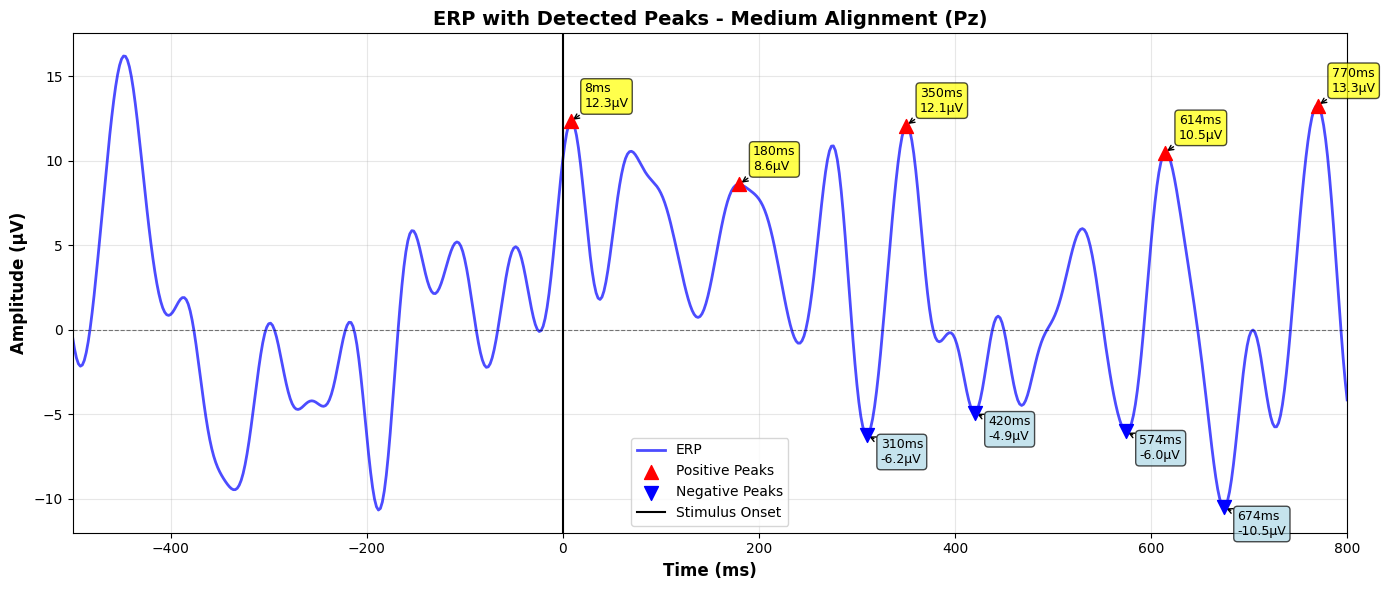

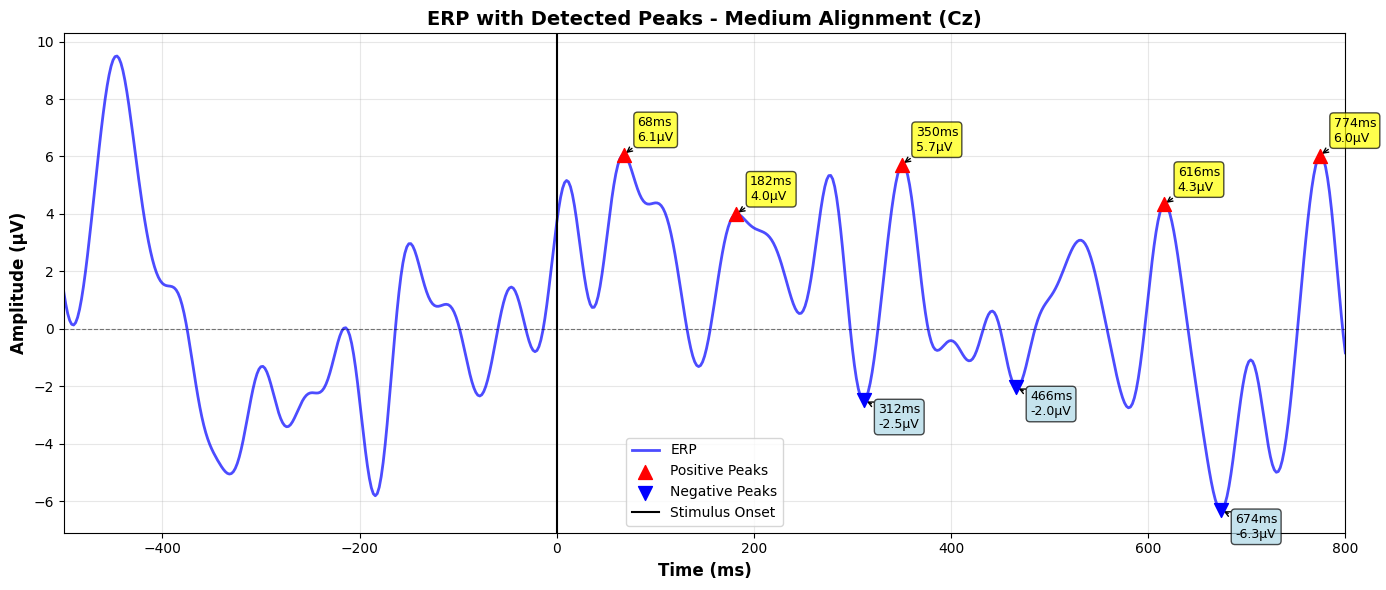

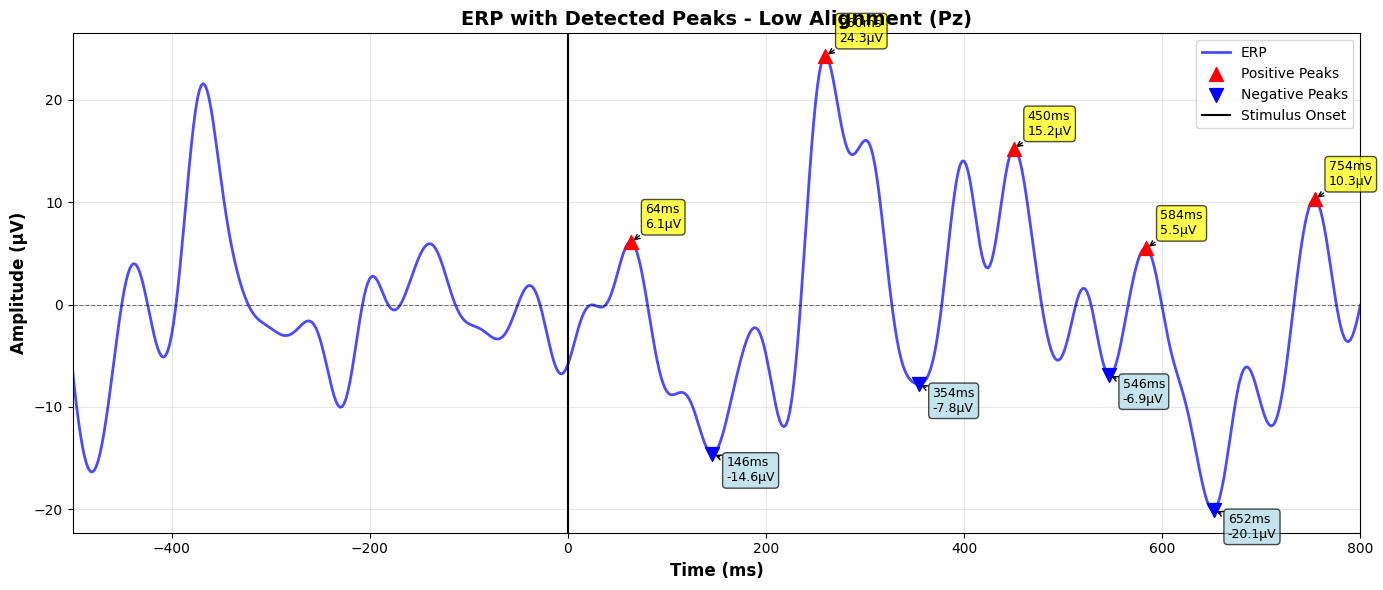

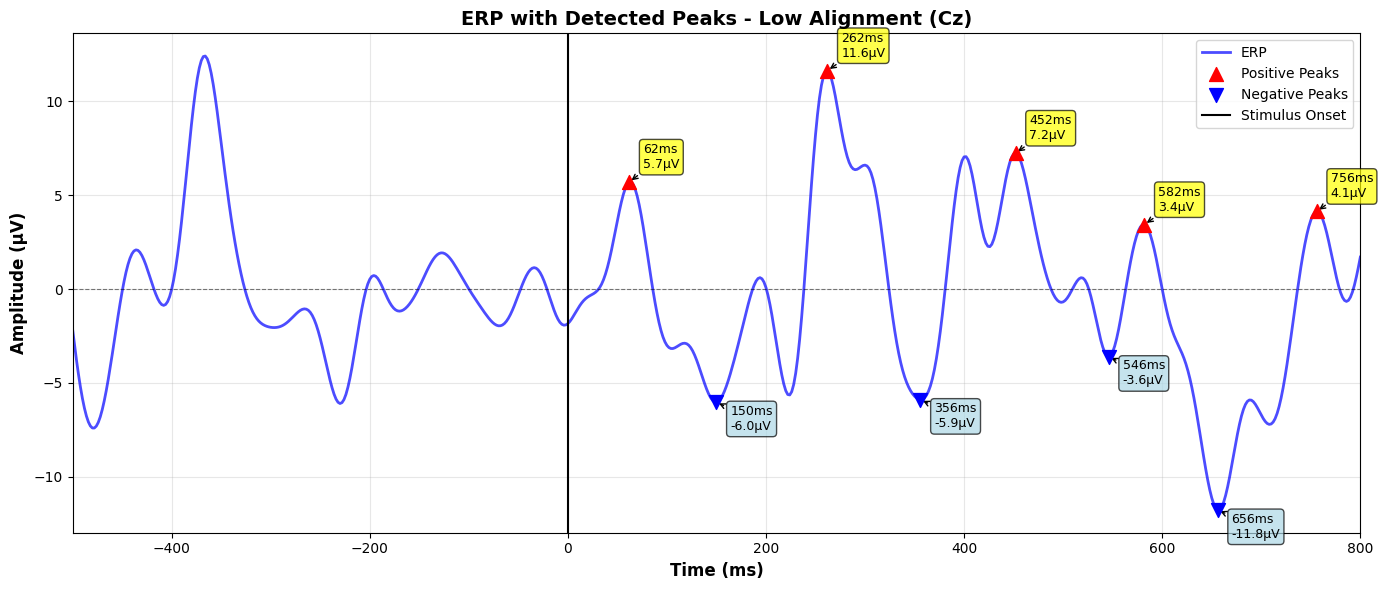

In [24]:
# Visualize detected peaks on ERP waveform
def plot_erp_with_peaks(evoked, peaks, channel='Pz', condition_name=''):
    """Plot ERP waveform with detected peaks marked."""
    if evoked is None or peaks is None:
        print(f"No data available for {condition_name}")
        return
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Get data
    ch_idx = evoked.ch_names.index(channel)
    times_ms = evoked.times * 1000
    data_uv = evoked.data[ch_idx, :] * 1e6
    
    # Plot ERP
    ax.plot(times_ms, data_uv, 'b-', linewidth=2, label='ERP', alpha=0.7)
    
    # Mark positive peaks
    if len(peaks['positive']['times']) > 0:
        ax.scatter(peaks['positive']['times'], peaks['positive']['amplitudes'], 
                  color='red', s=100, marker='^', zorder=5, label='Positive Peaks')
        # Annotate peaks
        for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
            ax.annotate(f'{t:.0f}ms\n{amp:.1f}µV', 
                       xy=(t, amp), xytext=(10, 10),
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Mark negative peaks
    if len(peaks['negative']['times']) > 0:
        ax.scatter(peaks['negative']['times'], peaks['negative']['amplitudes'],
                  color='blue', s=100, marker='v', zorder=5, label='Negative Peaks')
        # Annotate peaks
        for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
            ax.annotate(f'{t:.0f}ms\n{amp:.1f}µV',
                       xy=(t, amp), xytext=(10, -20),
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Reference lines
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=1.5, label='Stimulus Onset')
    
    # Formatting
    ax.set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
    ax.set_title(f'ERP with Detected Peaks - {condition_name} ({channel})', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([times_ms[0], times_ms[-1]])
    
    plt.tight_layout()
    plt.show()

# Plot for each available condition
for condition_name, evoked in [('High Alignment', evoked_high), 
                                ('Medium Alignment', evoked_medium), 
                                ('Low Alignment', evoked_low)]:
    if evoked is not None and condition_name.split()[0] in peak_results:
        for ch in ['Pz', 'Cz']:
            if ch in evoked.ch_names:
                cond_key = condition_name.split()[0]
                if ch in peak_results[cond_key]:
                    plot_erp_with_peaks(evoked, peak_results[cond_key][ch], 
                                       channel=ch, condition_name=condition_name)

In [25]:
# Create summary table of all detected peaks
peak_summary_data = []

for condition_name in peak_results.keys():
    for ch in peak_results[condition_name].keys():
        peaks = peak_results[condition_name][ch]
        
        # Add positive peaks
        for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
            peak_summary_data.append({
                'Condition': condition_name,
                'Channel': ch,
                'Polarity': 'Positive',
                'Peak_Number': i + 1,
                'Latency_ms': t,
                'Amplitude_uV': amp
            })
        
        # Add negative peaks
        for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
            peak_summary_data.append({
                'Condition': condition_name,
                'Channel': ch,
                'Polarity': 'Negative',
                'Peak_Number': i + 1,
                'Latency_ms': t,
                'Amplitude_uV': amp
            })

if peak_summary_data:
    df_peaks = pd.DataFrame(peak_summary_data)
    df_peaks = df_peaks.sort_values(['Condition', 'Channel', 'Latency_ms'])
    
    print("\n=== PEAK SUMMARY TABLE ===")
    print(df_peaks.to_string(index=False))
    
    # Save to CSV
    os.makedirs('./results', exist_ok=True)
    df_peaks.to_csv(f'./results/erp_peaks_session_{session_id:02d}.csv', index=False)
    print(f"\n✓ Peak summary saved to: ./results/erp_peaks_session_{session_id:02d}.csv")
else:
    print("No peaks detected")


=== PEAK SUMMARY TABLE ===
Condition Channel Polarity  Peak_Number  Latency_ms  Amplitude_uV
      Low      Cz Positive            1        62.0      5.700651
      Low      Cz Negative            1       150.0     -6.024409
      Low      Cz Positive            2       262.0     11.636448
      Low      Cz Negative            2       356.0     -5.888543
      Low      Cz Positive            3       452.0      7.240773
      Low      Cz Negative            3       546.0     -3.602260
      Low      Cz Positive            4       582.0      3.434432
      Low      Cz Negative            4       656.0    -11.770079
      Low      Cz Positive            5       756.0      4.139901
      Low      Fz Negative            1        24.0     -1.876640
      Low      Fz Positive            1       142.0      3.261632
      Low      Fz Negative            2       262.0     -9.706845
      Low      Fz Positive            2       362.0      2.537314
      Low      Fz Negative            3       40

## 14. Identify ERP Components

Match detected peaks to known ERP components based on latency and polarity.

In [26]:
# Define known ERP components with typical characteristics
# Based on cognitive neuroscience literature
erp_components_db = {
    'P1': {
        'latency_range': (80, 130),    # ms
        'polarity': 'Positive',
        'typical_channels': ['O1', 'O2', 'Oz', 'P7', 'P8', 'Pz'],
        'description': 'Early visual processing',
        'category': 'Sensory'
    },
    'N1': {
        'latency_range': (100, 200),
        'polarity': 'Negative',
        'typical_channels': ['P7', 'P8', 'Pz', 'Oz'],
        'description': 'Visual attention and discrimination',
        'category': 'Sensory'
    },
    'P2': {
        'latency_range': (150, 275),
        'polarity': 'Positive',
        'typical_channels': ['Cz', 'Pz', 'Fz'],
        'description': 'Stimulus evaluation and attention',
        'category': 'Cognitive'
    },
    'N2': {
        'latency_range': (200, 350),
        'polarity': 'Negative',
        'typical_channels': ['Fz', 'FCz', 'Cz'],
        'description': 'Conflict monitoring, cognitive control',
        'category': 'Cognitive'
    },
    'P3/P300': {
        'latency_range': (300, 600),
        'polarity': 'Positive',
        'typical_channels': ['Pz', 'Cz', 'CPz'],
        'description': 'Context updating, attention allocation',
        'category': 'Cognitive'
    },
    'N400': {
        'latency_range': (300, 500),
        'polarity': 'Negative',
        'typical_channels': ['Cz', 'Pz'],
        'description': 'Semantic processing, expectancy violation',
        'category': 'Language/Semantic'
    },
    'LPP': {
        'latency_range': (400, 800),
        'polarity': 'Positive',
        'typical_channels': ['Pz', 'Cz', 'CPz'],
        'description': 'Late Positive Potential - emotional/motivational processing',
        'category': 'Affective'
    },
    'CNV': {
        'latency_range': (200, 800),
        'polarity': 'Negative',
        'typical_channels': ['Cz', 'Fz'],
        'description': 'Contingent Negative Variation - anticipation/preparation',
        'category': 'Motor/Cognitive'
    }
}

def identify_erp_component(latency_ms, polarity, channel):
    """
    Identify which ERP component a peak might represent.
    
    Parameters:
    -----------
    latency_ms : float
        Peak latency in milliseconds
    polarity : str
        'Positive' or 'Negative'
    channel : str
        EEG channel name
    
    Returns:
    --------
    list of tuples: (component_name, confidence_score)
    """
    matches = []
    
    for comp_name, comp_info in erp_components_db.items():
        # Check polarity
        if comp_info['polarity'] != polarity:
            continue
        
        # Check latency range
        lat_min, lat_max = comp_info['latency_range']
        if not (lat_min <= latency_ms <= lat_max):
            continue
        
        # Calculate confidence based on channel match and latency fit
        confidence = 0.0
        
        # Channel match (50% of confidence)
        if channel in comp_info['typical_channels']:
            confidence += 0.5
        
        # Latency fit (50% of confidence) - how centered in the range
        lat_center = (lat_min + lat_max) / 2
        lat_range = lat_max - lat_min
        deviation = abs(latency_ms - lat_center) / lat_range
        latency_score = max(0, 0.5 * (1 - deviation))
        confidence += latency_score
        
        if confidence > 0:
            matches.append((comp_name, confidence))
    
    # Sort by confidence (highest first)
    matches.sort(key=lambda x: x[1], reverse=True)
    return matches

# Apply identification to all detected peaks
print("=== ERP COMPONENT IDENTIFICATION ===\n")

identified_components = []

for condition_name in peak_results.keys():
    for ch in peak_results[condition_name].keys():
        peaks = peak_results[condition_name][ch]
        
        # Process positive peaks
        for i, (t, amp) in enumerate(zip(peaks['positive']['times'], peaks['positive']['amplitudes'])):
            matches = identify_erp_component(t, 'Positive', ch)
            
            if matches:
                best_match, confidence = matches[0]
                identified_components.append({
                    'Condition': condition_name,
                    'Channel': ch,
                    'Latency_ms': t,
                    'Amplitude_uV': amp,
                    'Polarity': 'Positive',
                    'Identified_As': best_match,
                    'Confidence': confidence,
                    'Alternative_Matches': ', '.join([f"{m[0]}({m[1]:.2f})" for m in matches[1:3]]) if len(matches) > 1 else 'None',
                    'Description': erp_components_db[best_match]['description'],
                    'Category': erp_components_db[best_match]['category']
                })
        
        # Process negative peaks
        for i, (t, amp) in enumerate(zip(peaks['negative']['times'], peaks['negative']['amplitudes'])):
            matches = identify_erp_component(t, 'Negative', ch)
            
            if matches:
                best_match, confidence = matches[0]
                identified_components.append({
                    'Condition': condition_name,
                    'Channel': ch,
                    'Latency_ms': t,
                    'Amplitude_uV': amp,
                    'Polarity': 'Negative',
                    'Identified_As': best_match,
                    'Confidence': confidence,
                    'Alternative_Matches': ', '.join([f"{m[0]}({m[1]:.2f})" for m in matches[1:3]]) if len(matches) > 1 else 'None',
                    'Description': erp_components_db[best_match]['description'],
                    'Category': erp_components_db[best_match]['category']
                })

if identified_components:
    df_identified = pd.DataFrame(identified_components)
    df_identified = df_identified.sort_values(['Condition', 'Latency_ms'])
    
    print("\n" + "="*100)
    print("IDENTIFIED ERP COMPONENTS")
    print("="*100)
    print(df_identified[['Condition', 'Channel', 'Identified_As', 'Latency_ms', 
                        'Amplitude_uV', 'Confidence', 'Description']].to_string(index=False))
    
    # Save detailed results
    df_identified.to_csv(f'./results/erp_identified_session_{session_id:02d}.csv', index=False)
    print(f"\n✓ Identified components saved to: ./results/erp_identified_session_{session_id:02d}.csv")
    
    # Summary by component type
    print("\n" + "="*100)
    print("SUMMARY BY COMPONENT TYPE")
    print("="*100)
    summary = df_identified.groupby(['Condition', 'Identified_As']).agg({
        'Latency_ms': 'mean',
        'Amplitude_uV': 'mean',
        'Confidence': 'mean',
        'Channel': 'count'
    }).round(2)
    summary.columns = ['Avg_Latency_ms', 'Avg_Amplitude_uV', 'Avg_Confidence', 'N_Channels']
    print(summary)
else:
    print("No ERP components could be identified based on the current database.")

=== ERP COMPONENT IDENTIFICATION ===


IDENTIFIED ERP COMPONENTS
Condition Channel Identified_As  Latency_ms  Amplitude_uV  Confidence                                                 Description
      Low      Pz            N1       146.0    -14.572008    0.980000                         Visual attention and discrimination
      Low      Cz            N1       150.0     -6.024409    0.500000                         Visual attention and discrimination
      Low      Pz            P2       260.0     24.279831    0.810000                           Stimulus evaluation and attention
      Low      Cz            P2       262.0     11.636448    0.802000                           Stimulus evaluation and attention
      Low      Fz            N2       262.0     -9.706845    0.956667                      Conflict monitoring, cognitive control
      Low      Pz          N400       354.0     -7.765463    0.885000                   Semantic processing, expectancy violation
      Low      Cz        

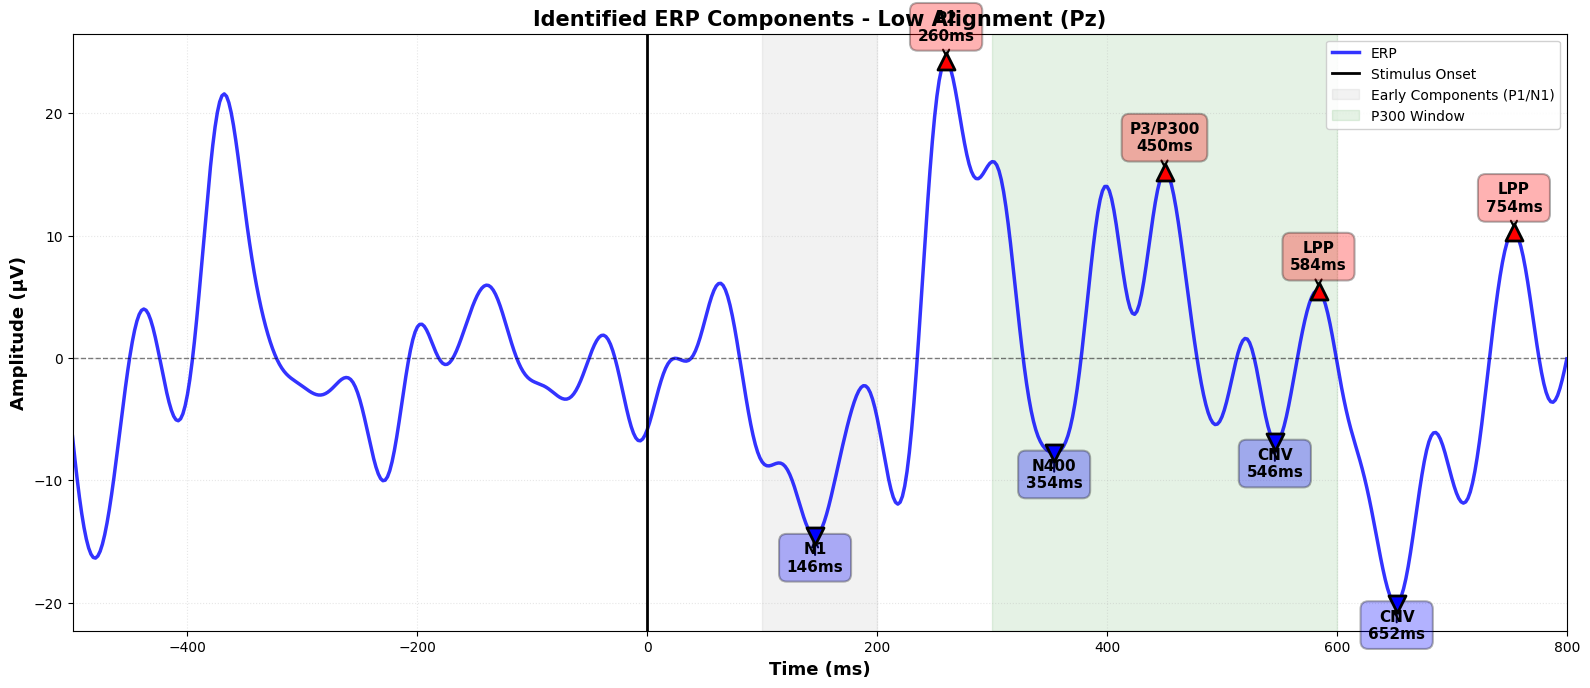

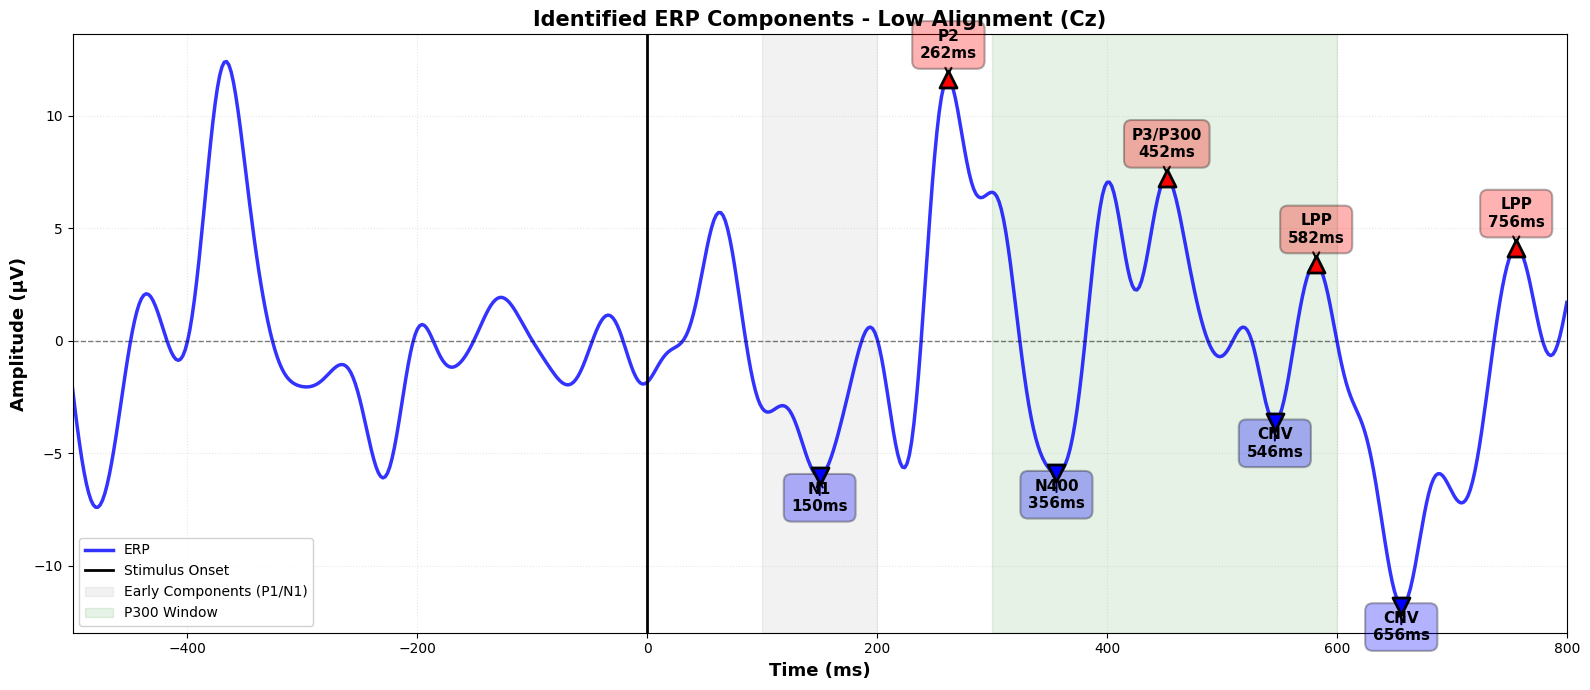

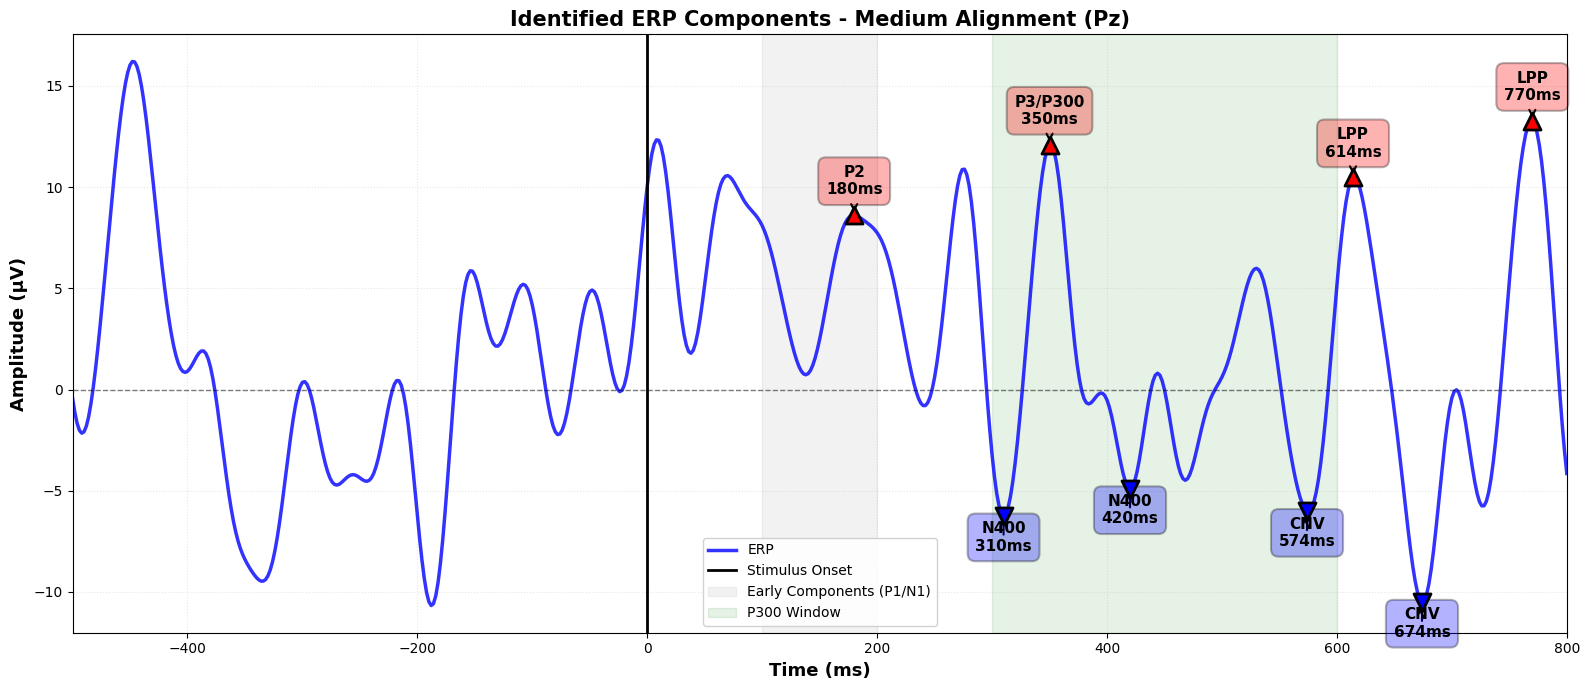

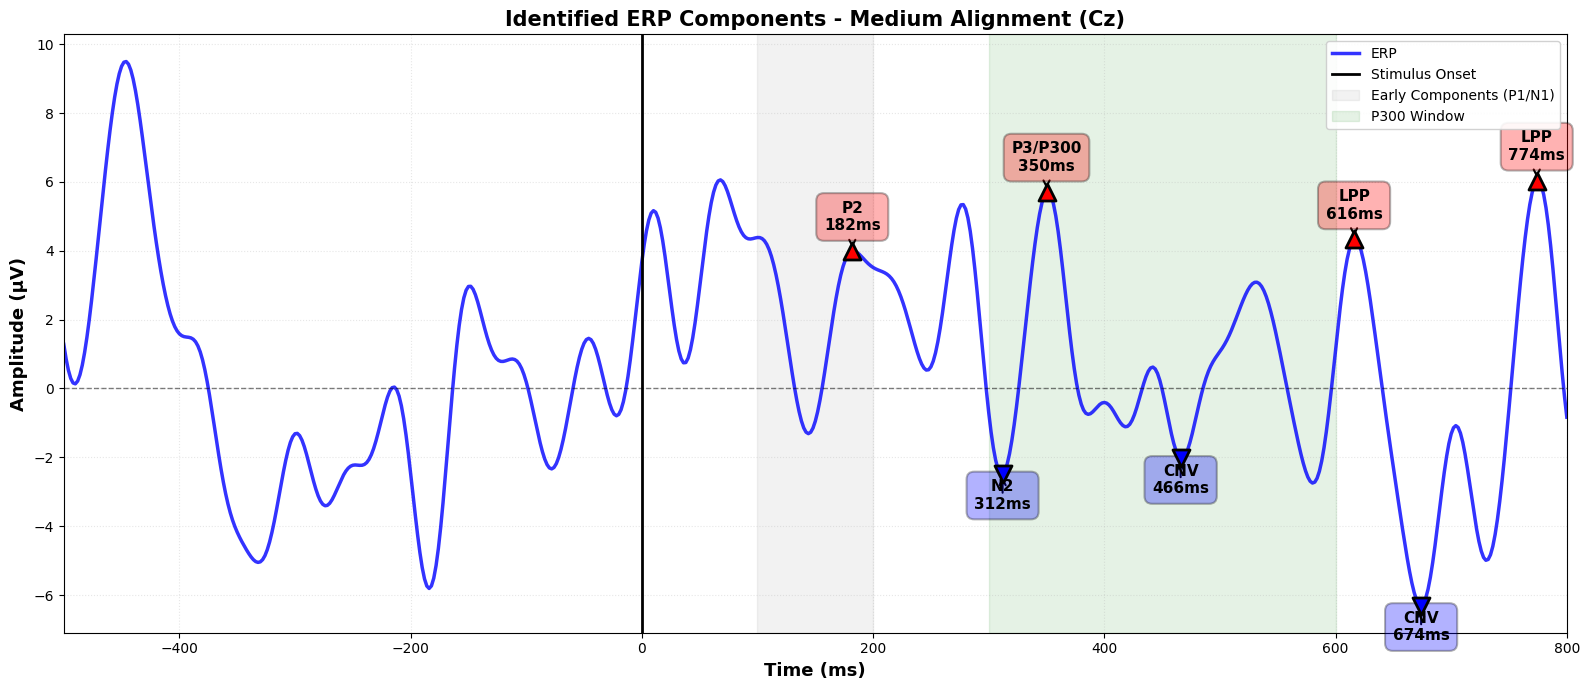

In [27]:
# Visualize identified components with labels
if identified_components:
    # Group by condition
    for condition_name in df_identified['Condition'].unique():
        df_cond = df_identified[df_identified['Condition'] == condition_name]
        
        # Get the evoked object for this condition
        evoked = None
        if condition_name == 'High':
            evoked = evoked_high
        elif condition_name == 'Medium':
            evoked = evoked_medium
        elif condition_name == 'Low':
            evoked = evoked_low
        
        if evoked is None:
            continue
        
        # Plot for Pz and Cz
        for channel in ['Pz', 'Cz']:
            if channel not in evoked.ch_names:
                continue
            
            df_ch = df_cond[df_cond['Channel'] == channel]
            if len(df_ch) == 0:
                continue
            
            fig, ax = plt.subplots(figsize=(16, 7))
            
            # Plot ERP
            ch_idx = evoked.ch_names.index(channel)
            times_ms = evoked.times * 1000
            data_uv = evoked.data[ch_idx, :] * 1e6
            ax.plot(times_ms, data_uv, 'b-', linewidth=2.5, label='ERP', alpha=0.8)
            
            # Mark and label identified components
            colors = {'Positive': 'red', 'Negative': 'blue'}
            markers = {'Positive': '^', 'Negative': 'v'}
            
            for _, row in df_ch.iterrows():
                color = colors[row['Polarity']]
                marker = markers[row['Polarity']]
                
                # Plot peak
                ax.scatter(row['Latency_ms'], row['Amplitude_uV'], 
                          color=color, s=150, marker=marker, zorder=5,
                          edgecolors='black', linewidths=2)
                
                # Add component label
                y_offset = 15 if row['Polarity'] == 'Positive' else -25
                label_text = f"{row['Identified_As']}\n{row['Latency_ms']:.0f}ms"
                
                ax.annotate(label_text,
                           xy=(row['Latency_ms'], row['Amplitude_uV']),
                           xytext=(0, y_offset),
                           textcoords='offset points',
                           fontsize=11,
                           fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.5', 
                                   facecolor=color, 
                                   alpha=0.3,
                                   edgecolor='black',
                                   linewidth=1.5),
                           arrowprops=dict(arrowstyle='->', 
                                         connectionstyle='arc3,rad=0',
                                         color='black',
                                         linewidth=1.5),
                           ha='center')
            
            # Reference lines
            ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
            ax.axvline(0, color='k', linestyle='-', linewidth=2, label='Stimulus Onset')
            
            # Shade typical time windows for major components
            ax.axvspan(100, 200, alpha=0.1, color='gray', label='Early Components (P1/N1)')
            ax.axvspan(300, 600, alpha=0.1, color='green', label='P300 Window')
            
            # Formatting
            ax.set_xlabel('Time (ms)', fontsize=13, fontweight='bold')
            ax.set_ylabel('Amplitude (µV)', fontsize=13, fontweight='bold')
            ax.set_title(f'Identified ERP Components - {condition_name} Alignment ({channel})', 
                        fontsize=15, fontweight='bold')
            ax.legend(loc='best', fontsize=10, framealpha=0.9)
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.set_xlim([times_ms[0], times_ms[-1]])
            
            plt.tight_layout()
            plt.show()
else:
    print("No components identified to visualize")

## 15. Data Quality Assessment

Critical quality checks for ERP validity before interpretation.

In [28]:
def assess_erp_quality(evoked, condition_name):
    """
    Assess ERP data quality based on neurophysiological plausibility.
    
    Returns quality report with warnings and recommendations.
    """
    if evoked is None:
        return None
    
    quality_report = {
        'condition': condition_name,
        'warnings': [],
        'recommendations': [],
        'is_valid': True
    }
    
    # Check 1: Amplitude range (should be ~5-30 µV for most components)
    data_uv = evoked.data * 1e6  # Convert to µV
    max_amp = np.max(np.abs(data_uv))
    mean_amp = np.mean(np.abs(data_uv))
    
    if max_amp > 50:
        quality_report['warnings'].append(
            f"⚠️ CRITICAL: Maximum amplitude {max_amp:.1f} µV exceeds typical range (5-30 µV). "
            f"Likely artifacts present (movement, muscle, poor electrode contact)."
        )
        quality_report['is_valid'] = False
        quality_report['recommendations'].append(
            "→ Check preprocessing: baseline correction, artifact rejection, referencing"
        )
    
    if max_amp > 100:
        quality_report['warnings'].append(
            f"⚠️ SEVERE: Amplitude {max_amp:.1f} µV is extremely high. "
            f"Data may be unusable without reprocessing."
        )
    
    # Check 2: Signal-to-noise ratio (smoothness)
    # Calculate variance of derivative as roughness measure
    for ch_idx in range(min(3, evoked.data.shape[0])):  # Check first 3 channels
        derivative = np.diff(evoked.data[ch_idx, :])
        roughness = np.std(derivative) / (np.std(evoked.data[ch_idx, :]) + 1e-10)
        
        if roughness > 0.15:
            quality_report['warnings'].append(
                f"⚠️ High-frequency noise detected in {evoked.ch_names[ch_idx]} (roughness={roughness:.3f}). "
                f"Signal appears 'jagged' rather than smooth."
            )
            quality_report['is_valid'] = False
            quality_report['recommendations'].append(
                f"→ Apply low-pass filter (e.g., 30 Hz) or increase averaging (more epochs)"
            )
            break
    
    # Check 3: Number of averaged epochs (from evoked.nave)
    n_epochs = evoked.nave
    if n_epochs < 15:
        quality_report['warnings'].append(
            f"⚠️ Only {n_epochs} epochs averaged. Minimum 15-20 recommended for stable ERPs."
        )
        quality_report['is_valid'] = False
        quality_report['recommendations'].append(
            "→ Collect more trials or relax artifact rejection criteria"
        )
    elif n_epochs < 30:
        quality_report['warnings'].append(
            f"ℹ️ {n_epochs} epochs averaged. 30+ recommended for robust results."
        )
    
    # Check 4: Baseline stability
    baseline_data = evoked.copy().crop(tmin=-0.2, tmax=0)
    baseline_std = np.std(baseline_data.data * 1e6)
    
    if baseline_std > 10:
        quality_report['warnings'].append(
            f"⚠️ Baseline period shows high variability (SD={baseline_std:.1f} µV). "
            f"Baseline correction may have failed."
        )
        quality_report['is_valid'] = False
        quality_report['recommendations'].append(
            "→ Verify baseline correction was applied correctly"
        )
    
    # Summary
    if quality_report['is_valid']:
        quality_report['summary'] = "✅ Data quality appears acceptable for ERP analysis"
    else:
        quality_report['summary'] = "❌ Data quality issues detected - interpret results with caution"
    
    return quality_report

# Assess quality for all conditions
print("="*100)
print("ERP DATA QUALITY ASSESSMENT")
print("="*100)

all_quality_reports = []

for condition_name, evoked in [('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]:
    if evoked is not None:
        print(f"\n{'='*100}")
        print(f"Condition: {condition_name} Alignment")
        print(f"{'='*100}")
        
        report = assess_erp_quality(evoked, condition_name)
        all_quality_reports.append(report)
        
        # Print summary
        print(f"\n{report['summary']}")
        print(f"\nNumber of averaged epochs: {evoked.nave}")
        
        data_uv = evoked.data * 1e6
        print(f"Amplitude range: {np.min(data_uv):.1f} to {np.max(data_uv):.1f} µV")
        print(f"Mean absolute amplitude: {np.mean(np.abs(data_uv)):.1f} µV")
        
        # Print warnings
        if report['warnings']:
            print(f"\n⚠️ WARNINGS ({len(report['warnings'])}):")
            for warning in report['warnings']:
                print(f"  {warning}")
        
        # Print recommendations
        if report['recommendations']:
            print(f"\n💡 RECOMMENDATIONS:")
            for rec in report['recommendations']:
                print(f"  {rec}")

print(f"\n{'='*100}")
print("OVERALL ASSESSMENT")
print(f"{'='*100}")

valid_conditions = [r['condition'] for r in all_quality_reports if r['is_valid']]
invalid_conditions = [r['condition'] for r in all_quality_reports if not r['is_valid']]

if valid_conditions:
    print(f"\n✅ Valid for analysis: {', '.join(valid_conditions)}")
if invalid_conditions:
    print(f"\n❌ Quality issues detected: {', '.join(invalid_conditions)}")
    print(f"\n⚠️ CRITICAL: Peak detection and component identification may be unreliable for these conditions!")
    print(f"   Identified 'components' in poor-quality data likely represent:")
    print(f"   • Artifacts (movement, muscle, eye blinks)")
    print(f"   • Noise peaks rather than neural activity")
    print(f"   • Random fluctuations due to insufficient averaging")

print(f"\n{'='*100}")

ERP DATA QUALITY ASSESSMENT

Condition: Medium Alignment

❌ Data quality issues detected - interpret results with caution

Number of averaged epochs: 3
Amplitude range: -26.3 to 27.6 µV
Mean absolute amplitude: 4.2 µV

⚠️ WARNINGS (1):
  ⚠️ Only 3 epochs averaged. Minimum 15-20 recommended for stable ERPs.

💡 RECOMMENDATIONS:
  → Collect more trials or relax artifact rejection criteria

Condition: Low Alignment

❌ Data quality issues detected - interpret results with caution

Number of averaged epochs: 2
Amplitude range: -31.4 to 37.7 µV
Mean absolute amplitude: 3.6 µV

⚠️ WARNINGS (1):
  ⚠️ Only 2 epochs averaged. Minimum 15-20 recommended for stable ERPs.

💡 RECOMMENDATIONS:
  → Collect more trials or relax artifact rejection criteria

OVERALL ASSESSMENT

❌ Quality issues detected: Medium, Low

⚠️ CRITICAL: Peak detection and component identification may be unreliable for these conditions!
   Identified 'components' in poor-quality data likely represent:
   • Artifacts (movement, mus

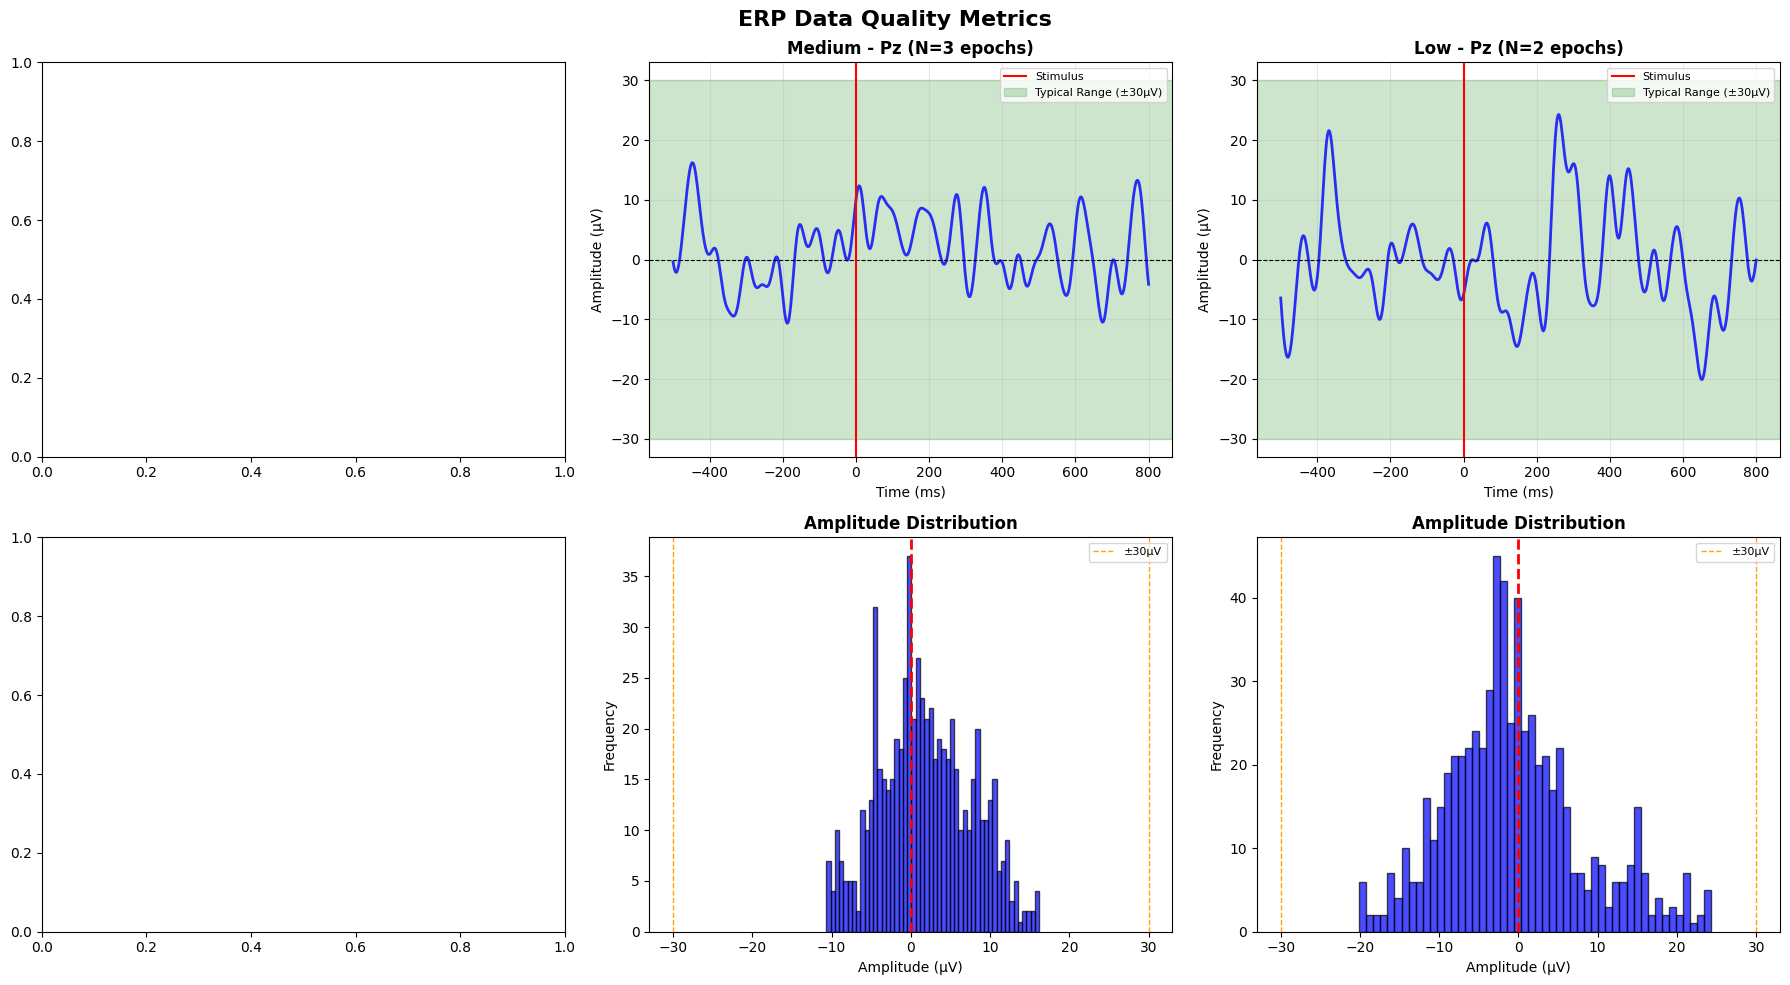


QUALITY STATISTICS SUMMARY
Condition  N_Epochs  Min_Amp_µV  Max_Amp_µV  Mean_Abs_µV    SD_µV Quality
   Medium         3  -26.307838   27.582454     4.165114 5.820613       ❌
      Low         2  -31.376517   37.729812     3.565078 5.239744       ❌

✓ Quality report saved to: ./results/erp_quality_session_01.csv


In [29]:
# Visualize quality metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ERP Data Quality Metrics', fontsize=16, fontweight='bold')

for idx, (condition_name, evoked) in enumerate([('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]):
    if evoked is None:
        continue
    
    # Get Pz channel
    if 'Pz' in evoked.ch_names:
        ch_idx = evoked.ch_names.index('Pz')
        times_ms = evoked.times * 1000
        data_uv = evoked.data[ch_idx, :] * 1e6
        
        # Plot 1: ERP waveform with quality overlay
        ax = axes[0, idx]
        ax.plot(times_ms, data_uv, 'b-', linewidth=2, alpha=0.8)
        ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
        ax.axvline(0, color='r', linestyle='-', linewidth=1.5, label='Stimulus')
        
        # Shade acceptable amplitude range
        ax.axhspan(-30, 30, alpha=0.2, color='green', label='Typical Range (±30µV)')
        
        # Mark if exceeds range
        if np.max(np.abs(data_uv)) > 50:
            ax.axhspan(-50, 50, alpha=0.15, color='orange', label='Warning (±50µV)')
        if np.max(np.abs(data_uv)) > 100:
            ax.axhspan(-100, 100, alpha=0.1, color='red', label='Critical (±100µV)')
        
        ax.set_title(f'{condition_name} - Pz (N={evoked.nave} epochs)', fontweight='bold')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude (µV)')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Amplitude distribution
        ax = axes[1, idx]
        ax.hist(data_uv, bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(0, color='r', linestyle='--', linewidth=2)
        ax.axvline(-30, color='orange', linestyle='--', linewidth=1, label='±30µV')
        ax.axvline(30, color='orange', linestyle='--', linewidth=1)
        ax.set_title(f'Amplitude Distribution', fontweight='bold')
        ax.set_xlabel('Amplitude (µV)')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics table
quality_stats = []
for condition_name, evoked in [('High', evoked_high), ('Medium', evoked_medium), ('Low', evoked_low)]:
    if evoked is not None:
        data_uv = evoked.data * 1e6
        quality_stats.append({
            'Condition': condition_name,
            'N_Epochs': evoked.nave,
            'Min_Amp_µV': np.min(data_uv),
            'Max_Amp_µV': np.max(data_uv),
            'Mean_Abs_µV': np.mean(np.abs(data_uv)),
            'SD_µV': np.std(data_uv),
            'Quality': '✅' if all_quality_reports[[r['condition'] for r in all_quality_reports].index(condition_name)]['is_valid'] else '❌'
        })

if quality_stats:
    df_quality = pd.DataFrame(quality_stats)
    print("\n" + "="*100)
    print("QUALITY STATISTICS SUMMARY")
    print("="*100)
    print(df_quality.to_string(index=False))
    
    # Save quality report
    df_quality.to_csv(f'./results/erp_quality_session_{session_id:02d}.csv', index=False)
    print(f"\n✓ Quality report saved to: ./results/erp_quality_session_{session_id:02d}.csv")